In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import sem
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
loss_list_net = []
p_list_net = []
loss_net_list_net = []
p_net_list_net = []

for network_name in ["DAGMA_thresholdAdaptive", "STRING", "BIOGRID", "ChIP_hTFtarget", "ChIP_TIP", "ChIP_TIP_GM12878", "CoExpr_ENCODE_GM12878_0.75", "CoExpr_GTEx_EBV_0.75", "Random_ER", "Random_SF", "MLP"]:
    
    loss_list = []
    p_list = []
    loss_net_list = []
    p_net_list = []

    for rs in range(1, 6):
        Y_train = pd.read_csv("../../result/input_GTEx_phyloP/stratified_%d/Y_train" % rs, sep="\t", index_col=0)
        Y_valid = pd.read_csv("../../result/input_GTEx_phyloP/stratified_%d/Y_valid" % rs, sep="\t", index_col=0)
        Y_test = pd.read_csv("../../result/input_GTEx_phyloP/stratified_%d/Y_test" % rs, sep="\t", index_col=0)
        Y = pd.concat([Y_train, Y_valid, Y_test]) * 100
        test_mask = pd.DataFrame([False] * len(Y_train) + [False] * len(Y_valid) + [True] * len(Y_test))
        test_mask.index = Y.index

        # re-order to match the network index
        valid_genes = pd.read_csv("../../result/network_GTEx_phyloP/valid_genes", sep="\t")
        Y = Y.loc[valid_genes['genes'].values]
        test_mask = test_mask.loc[valid_genes['genes'].values]
        test_mask = test_mask[0].values

        # mask of whether a test node is in the DAGMA graph
        dag = pd.read_csv("../../result/network_GTEx_phyloP/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
        id2genes = valid_genes.set_index("ID")['genes'].to_dict()
        dag[0] = dag[0].map(id2genes)
        dag[1] = dag[1].map(id2genes)
        dag_genes = list(set.union(set(dag[0]), set(dag[1])))
        dag_mask = Y.index.isin(dag_genes)

        for rep in range(10):

            if network_name == "MLP":
                prefix = "../../result/model_GTEx_phyloP_MLP/%d/model%d" % (rs, rep)
                with open(prefix+".para", "rb") as f:
                    best_params, X1, out = pickle.load(f)            
            else:
                prefix = "../../result/model_GTEx_phyloP_GCN/%s/%d/model%d" % (network_name, rs, rep)
                with open(prefix+".para", "rb") as f:
                    best_params, X1, out = pickle.load(f)

            # result on the test set
            Y_pred = out.flatten()[test_mask]
            Y_true = Y.values.flatten()[test_mask]
            loss_list.append(mean_squared_error(Y_true, Y_pred))
            p_list.append(pearsonr(Y_true, Y_pred)[0])

            # result on the test set, but the test node also in DAGMA
            Y_pred = out.flatten()[test_mask & dag_mask]
            Y_true = Y.values.flatten()[test_mask & dag_mask]
            loss_net_list.append(mean_squared_error(Y_true, Y_pred))
            p_net_list.append(pearsonr(Y_true, Y_pred)[0])
    
    bool_list = ~np.isnan(p_net_list)
    loss_list = np.array(loss_list)[bool_list]
    p_list = np.array(p_list)[bool_list]
    loss_net_list = np.array(loss_net_list)[bool_list]
    p_net_list = np.array(p_net_list)[bool_list]
    
    loss_list_net.append(loss_list)
    p_list_net.append(p_list)
    loss_net_list_net.append(loss_net_list)
    p_net_list_net.append(p_net_list)

In [3]:
sig = []
for ii in range(len(loss_list_net)):
    if ttest_ind(loss_list_net[ii], loss_list_net[0], equal_var=False)[1] <= 0.05:
        sig.append(True)
    else:
        sig.append(False)
sig = np.array(sig)

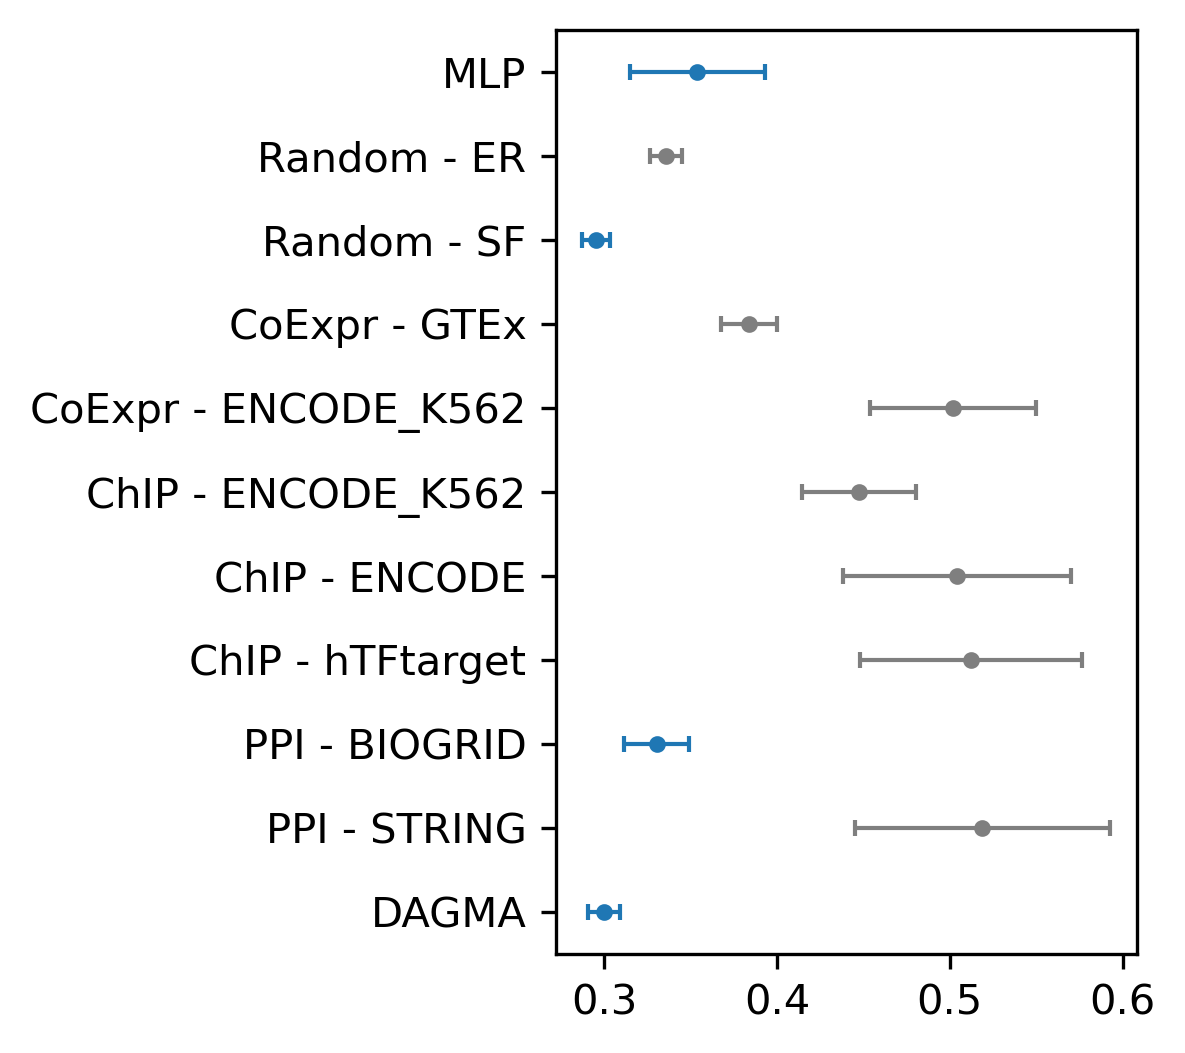

In [4]:
mean_vector = np.array([ii.mean() for ii in loss_list_net])
std_vector = np.array([sem(ii) for ii in loss_list_net])
plt.figure(dpi=300, figsize=(2.5, 4))
plt.errorbar(y=np.arange(len(mean_vector))[sig], x=mean_vector[sig], xerr=std_vector[sig], fmt='.', elinewidth=1, capsize=2, color="tab:grey")
plt.errorbar(y=np.arange(len(mean_vector))[~sig], x=mean_vector[~sig], xerr=std_vector[~sig], fmt='.', elinewidth=1, capsize=2, color="tab:blue")
plt.yticks(range(len(mean_vector)), labels=["DAGMA", "PPI - STRING", "PPI - BIOGRID", "ChIP - hTFtarget", "ChIP - ENCODE", "ChIP - ENCODE_K562", "CoExpr - ENCODE_K562", "CoExpr - GTEx", "Random - SF", "Random - ER", "MLP"])
plt.xticks([3000, 4000, 5000, 6000], labels=[0.3, 0.4, 0.5, 0.6])
plt.savefig("./mse.pdf", dpi='figure', bbox_inches="tight")

In [5]:
sig = []
for ii in range(len(p_list_net)):
    if ttest_ind(p_list_net[ii], p_list_net[0], equal_var=False)[1] <= 0.05:
        sig.append(True)
    else:
        sig.append(False)
sig = np.array(sig)

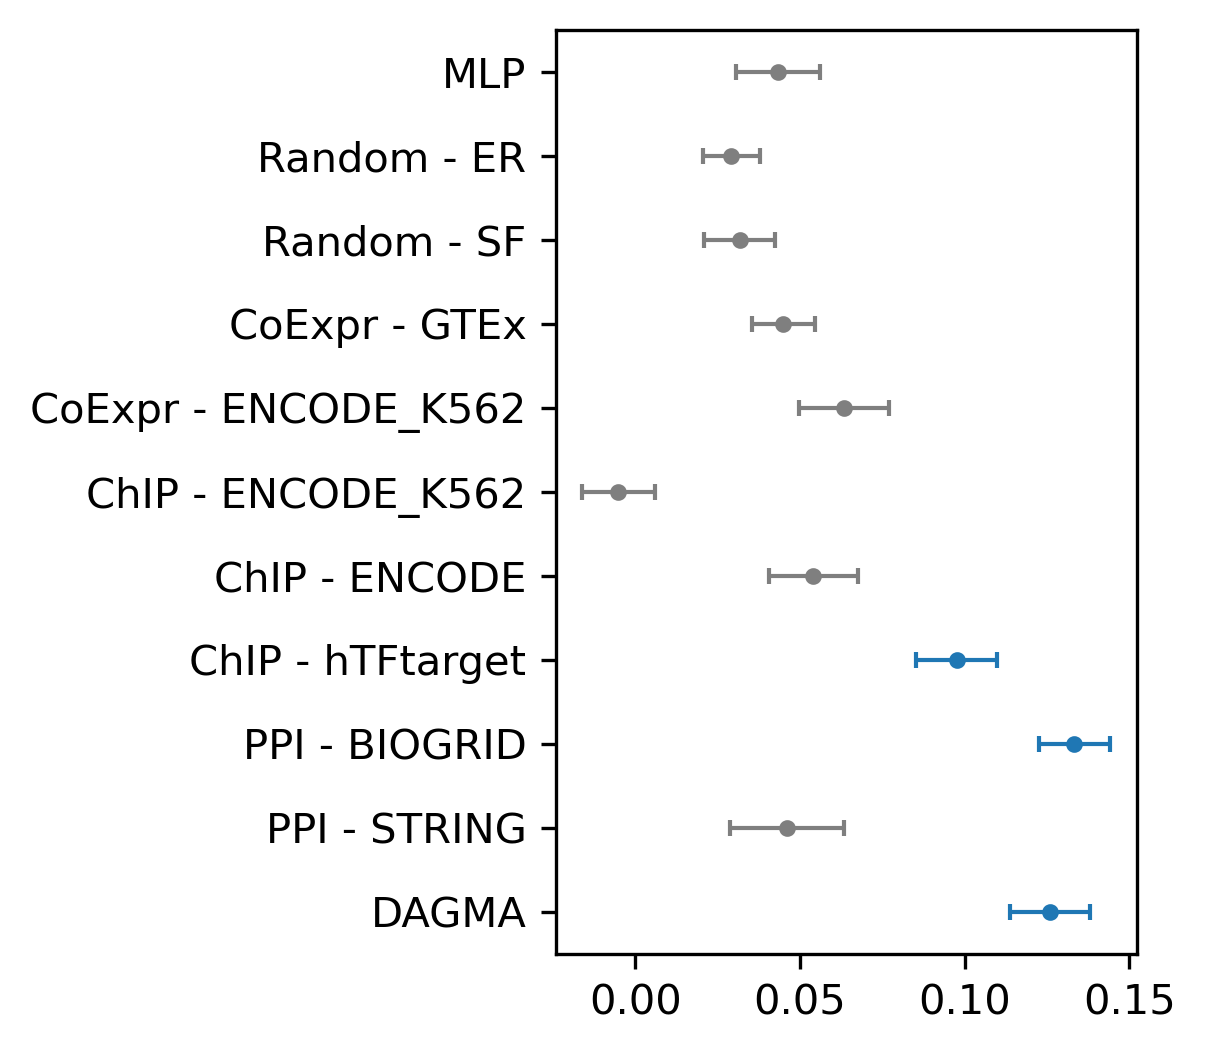

In [6]:
mean_vector = np.array([ii.mean() for ii in p_list_net])
std_vector = np.array([sem(ii) for ii in p_list_net])
plt.figure(dpi=300, figsize=(2.5, 4))
plt.errorbar(y=np.arange(len(mean_vector))[sig], x=mean_vector[sig], xerr=std_vector[sig], fmt='.', elinewidth=1, capsize=2, color="tab:grey")
plt.errorbar(y=np.arange(len(mean_vector))[~sig], x=mean_vector[~sig], xerr=std_vector[~sig], fmt='.', elinewidth=1, capsize=2, color="tab:blue")
plt.yticks(range(len(mean_vector)), labels=["DAGMA", "PPI - STRING", "PPI - BIOGRID", "ChIP - hTFtarget", "ChIP - ENCODE", "ChIP - ENCODE_K562", "CoExpr - ENCODE_K562", "CoExpr - GTEx", "Random - SF", "Random - ER", "MLP"])
plt.savefig("./corr.pdf", dpi='figure', bbox_inches="tight")